In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# this function / method should NOT be in the MultiRNN class
def split_data(data_path, length):
    df = pd.read_csv(data_path, index_col=0, parse_dates=True)
    train = df.iloc[:-length]
    test = df.iloc[-length:]

    return train, test

In [ ]:
def create_sub_df(train, test):
    # this snippet should be inside of method 
    # "generate_dataset_per_column_with_original_index"
    datasets = {
    "train" : {col:train[col] for col in train.columns},
    "test" : {col:test[col] for col in test.columns}
    }

    return datasets

In [ ]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.transform(test)

    return scaled_train, scaled_test

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
def create_generator(scaled_train, scaled_test, 
                     length, batch_size):
    
    generator = TimeseriesGenerator(scaled_train,
                                    scaled_test,
                                    length=length,
                                    batch_size=batch_size)
    
    # create validation generator
    val_generator = TimeseriesGenerator(scaled_test,
                                        scaled_test,
                                        length=length, 
                                        batch_size=batch_size)
    
    return generator, val_generator

In [ ]:
# nn_params = {"units" : length + 1,
#              "activation" : "relu",
#              "input_shape" : (length, 1),
#              "optimizer" : "adam",
#              "loss" : "mse"}

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
def create_LSTM(units, activation, loss,
                    input_shape, optimizer,
                    hidden_layers=1):
    
    model = Sequential()

    for i in range(hidden_layers):
        model.add(LSTM(units, activation=activation, 
                       input_shape=input_shape))
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss=loss)

    return model

In [ ]:
def fit_LSTM(model, generator, val_generator,
             monitor="val_loss", patience=2,
             epochs=10, batch_size=32):
    early_stop = EarlyStopping(monitor=monitor, 
                               patience=patience)

    result = model.fit(generator,
                       validation_data=val_generator,
                       epochs=epochs,
                       callbacks=[early_stop],
                       batch_size=batch_size)
    
    return result

In [ ]:
def eval(model, scaled_train, 
         test, length, scaler):
    test_preds = []

    first_eval_batch = scaled_train[-length:]
    current_batch = first_eval_batch.reshape((1, length, 1))

    for i in range(len(test)):
        current_pred = model.predict(current_batch)[0]
        test_preds.append(current_pred)
        current_batch = np.append(current_batch[:,1:,:], 
                                  [[current_pred]], axis=1)
        
    true_predictions = scaler.inverse_transform(test_preds)
    test["Predictions"] = true_predictions

    return test.plot()

In [22]:
# following Robert's example
length = 288
train, test = split_data("../data/energydata_complete.csv", length)

In [23]:
train.index

DatetimeIndex(['2016-01-11 17:00:00', '2016-01-11 17:10:00',
               '2016-01-11 17:20:00', '2016-01-11 17:30:00',
               '2016-01-11 17:40:00', '2016-01-11 17:50:00',
               '2016-01-11 18:00:00', '2016-01-11 18:10:00',
               '2016-01-11 18:20:00', '2016-01-11 18:30:00',
               ...
               '2016-05-25 16:30:00', '2016-05-25 16:40:00',
               '2016-05-25 16:50:00', '2016-05-25 17:00:00',
               '2016-05-25 17:10:00', '2016-05-25 17:20:00',
               '2016-05-25 17:30:00', '2016-05-25 17:40:00',
               '2016-05-25 17:50:00', '2016-05-25 18:00:00'],
              dtype='datetime64[ns]', name='date', length=19447, freq=None)

In [26]:
datasets = create_sub_df(train, test)

In [28]:
# scaling
scaled_lights_train, scaled_lights_test = scale_data(datasets["train"]["lights"].values.reshape(-1,1), 
                                                     datasets["test"]["lights"].values.reshape(-1,1))

In [7]:
# Time Series Generator
from keras.preprocessing.sequence import TimeseriesGenerator
length = 288
batch_size = 10
epochs = 20
nn_params = {"units" : length + 1,
             "activation" : "relu",
             "input_shape" : (length, 1),
             "optimizer" : "adam",
             "loss" : "mse"}

# generator = TimeseriesGenerator(scaled_lights_train,
#                                 scaled_lights_train,
#                                 length=length,
#                                 batch_size=batch_size)

generator, val_generator = create_generator(scaled_lights_train, 
                                            scaled_lights_test, 
                                            length, batch_size)

2024-05-14 10:20:07.303832: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 10:20:07.303905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 10:20:07.304560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 10:20:07.311970: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
X, y = generator[0]

print(f"For array : \n{X.flatten()}")
print(f"Predict this y : {y}")

For array : 
[0.42857143 0.42857143 0.42857143 ... 0.14285714 0.         0.14285714]
Predict this y : [[0.        ]
 [0.14285714]
 [0.        ]
 [0.        ]
 [0.14285714]
 [0.        ]
 [0.14285714]
 [0.        ]
 [0.14285714]
 [0.14285714]]


In [9]:
# create model
from keras.models import Sequential
from keras.layers import LSTM, Dense

# lights_model = Sequential()
# lights_model.add(LSTM(units=nn_params["units"],
#                       activation=nn_params["activation"],
#                       input_shape=nn_params["input_shape"]))
# lights_model.add(Dense(units=1)) # output layer
# lights_model.compile(optimizer=nn_params["optimizer"], loss=nn_params["loss"])
# lights_model.summary()

lights_model = create_LSTM(units=nn_params["units"],
                           activation=nn_params["activation"],
                           input_shape=nn_params["input_shape"],
                           optimizer=nn_params["optimizer"],
                           loss=nn_params["loss"],
                           hidden_layers=1)

lights_model.summary()

2024-05-14 10:20:08.678187: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 10:20:08.703803: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-14 10:20:08.704008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 289)               336396    
                                                                 
 dense (Dense)               (None, 1)                 290       
                                                                 
Total params: 336686 (1.28 MB)
Trainable params: 336686 (1.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# early stopping
from keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor="val_loss", patience=2)

In [11]:
# create validation generator
# val_generator = TimeseriesGenerator(scaled_test,
#                                     scaled_test,
#                                     length=length, 
#                                     batch_size=batch_size)

In [12]:
# fit or train the model
# light_res = lights_model.fit(generator,
#                              validation_data=val_generator,
#                              epochs=epochs,
#                              callbacks=[early_stop],
#                              batch_size=batch_size)

Epoch 1/20


2024-05-14 10:20:10.492809: I external/local_xla/xla/service/service.cc:168] XLA service 0x704fb9abff60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-14 10:20:10.492831: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-14 10:20:10.497811: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-14 10:20:10.510403: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1715674810.589600   13878 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1113/1113 [==============================] - 167s 149ms/step - loss: 0.0065 - val_loss: 0.0026
Epoch 2/20
1113/1113 [==============================] - 165s 148ms/step - loss: 0.0056 - val_loss: 0.0025
Epoch 3/20
1113/1113 [==============================] - 165s 148ms/step - loss: 0.0055 - val_loss: 0.0025
Epoch 4/20
1113/1113 [==============================] - 165s 148ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 5/20
1113/1113 [==============================] - 165s 149ms/step - loss: 0.0054 - val_loss: 0.0024
Epoch 6/20
1113/1113 [==============================] - 165s 148ms/step - loss: 0.0054 - val_loss: 0.0023
Epoch 7/20
1113/1113 [==============================] - 165s 148ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 8/20
1113/1113 [==============================] - 164s 148ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 9/20
1113/1113 [==============================] - 166s 149ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 10/20
1113/1113 [==============================] - 

<Axes: >

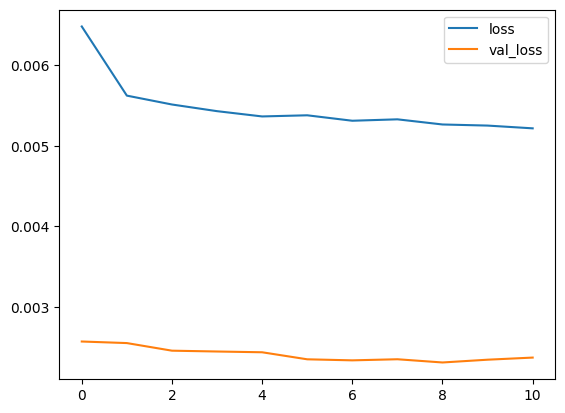

In [13]:
# plot the loss
# losses = pd.DataFrame(light_res.history)
# losses.plot()

In [14]:
# # evaluate the model
# first_eval_batch = scaled_train[-length:]
# first_eval_batch = first_eval_batch.reshape((1, length, 1))
# lights_model.predict(first_eval_batch)

1/1 [==============================] - 0s 146ms/step


array([[0.02157257]], dtype=float32)

In [15]:
# scaled_test[0]

array([0.])

In [16]:
# test_predictions = []
 
# first_eval_batch = scaled_train[-length:]
# current_batch = first_eval_batch.reshape((1, length, 1))
 
# for i in range(len(test)):
   
#     # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
#     current_pred = lights_model.predict(current_batch)[0]
   
#     # store prediction
#     test_predictions.append(current_pred)
   
#     # update batch to now include prediction and drop first value
#     current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 46ms/step


In [17]:
# test_predictions # we need to do inverse scaling

[array([0.02157257], dtype=float32),
 array([0.02167334], dtype=float32),
 array([0.02100288], dtype=float32),
 array([0.01983484], dtype=float32),
 array([0.01840224], dtype=float32),
 array([0.01692753], dtype=float32),
 array([0.01555991], dtype=float32),
 array([0.01437564], dtype=float32),
 array([0.01339805], dtype=float32),
 array([0.01261847], dtype=float32),
 array([0.01201234], dtype=float32),
 array([0.01154971], dtype=float32),
 array([0.01120132], dtype=float32),
 array([0.01094144], dtype=float32),
 array([0.01074884], dtype=float32),
 array([0.01060667], dtype=float32),
 array([0.01050201], dtype=float32),
 array([0.01042506], dtype=float32),
 array([0.01036852], dtype=float32),
 array([0.01032698], dtype=float32),
 array([0.01029647], dtype=float32),
 array([0.01027405], dtype=float32),
 array([0.01025757], dtype=float32),
 array([0.01024547], dtype=float32),
 array([0.01023658], dtype=float32),
 array([0.01023005], dtype=float32),
 array([0.01022526], dtype=float32),
 

In [18]:
# true_predictions = scaler.inverse_transform(test_predictions)
# true_predictions

array([[1.51007999],
       [1.51713356],
       [1.47020129],
       ...,
       [0.71484968],
       [0.71484968],
       [0.71484968]])

In [19]:
# test["prediction"] = true_predictions
# test

,lights,prediction
date,,
2016-05-01 00:00:00,0,1.510080
2016-05-01 00:10:00,0,1.517134
2016-05-01 00:20:00,0,1.470201
2016-05-01 00:30:00,0,1.388438
2016-05-01 00:40:00,0,1.288157
...,...,...
2016-05-27 17:20:00,0,0.714850
2016-05-27 17:30:00,0,0.714850
2016-05-27 17:40:00,10,0.714850


<Axes: xlabel='date'>

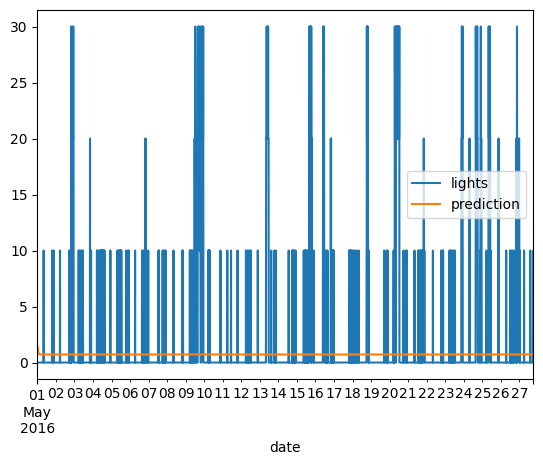

In [20]:
test.plot()